In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from tqdm import tqdm
from PIL import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors as mcolors

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, auc, precision_recall_curve
import torch.nn.functional as F
from torchvision import models

from utils import *

In [6]:
# Set plots style
plt.style.use('seaborn-v0_8-paper')

# Get the default color cycle from the current style
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
blue = default_colors[0]
orange = default_colors[1]

## Load the data

In [2]:
# Define transform to reshape image to 256x256 and normalise to ImageNet standards
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225]
        )
    ])

In [3]:
# img_dir = "C:/Users/gatla/OneDrive/BSE/Thesis/labelled_dataset/all_frames"
img_dir = "/Users/viktoriia/Desktop/new_labels/frames"

# Define datasets for val/test
val_dataset = WarDataset(img_dir, 'data/val_labels.csv', transform=transform)
test_dataset = WarDataset(img_dir, 'data/test_labels.csv', transform=transform)

# Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Load the model

In [4]:
# Define model architecture to load weights into
trained_model = torchvision.models.resnet50(weights=("pretrained", models.ResNet50_Weights.IMAGENET1K_V1))

num_ftrs = trained_model.fc.in_features

trained_model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1)
)

# Load weights from optimal model
# weights_path = "C:/Users/gatla/Downloads/resnet50_TL-All.pth"
weights_path = "/Users/viktoriia/Desktop/thesis/pytorch/model_weights/resnet50_TL-All.pth"
trained_model.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))

# Move the model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
trained_model.to(device)

/Users/viktoriia/my_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Test predictions

In [5]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)
val_images, val_labels, val_probs = evaluate_model_with_images(trained_model, val_loader, device=device)

Evaluating: 100%|████████████████████████████| 49/49 [00:31<00:00,  1.54batch/s]


### ROC-AUC curve

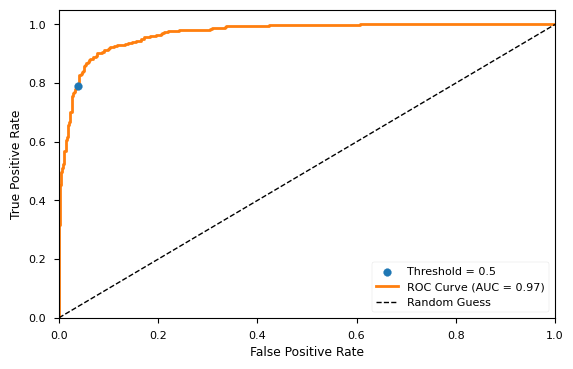

Threshold 0.5: FPR = 0.03884297520661157 TPR = 0.7911764705882353


In [8]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, val_probs)

# Find the index of the threshold closest to 0.5
threshold_05_idx = np.argmin(np.abs(thresholds - 0.5))

# Compute ROC area
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6.4, 4))

plt.scatter(fpr[threshold_05_idx], tpr[threshold_05_idx], color=blue, label='Threshold = 0.5', zorder=2)
plt.plot(fpr, tpr, color=orange, lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc, zorder=0)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--',  label='Random Guess', zorder=0)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig(
    'report_charts/ROC.pdf',
    bbox_inches='tight',
)


plt.show()

print('Threshold 0.5: FPR =', fpr[threshold_05_idx], 'TPR =', tpr[threshold_05_idx])

### Precision and Recall Curve

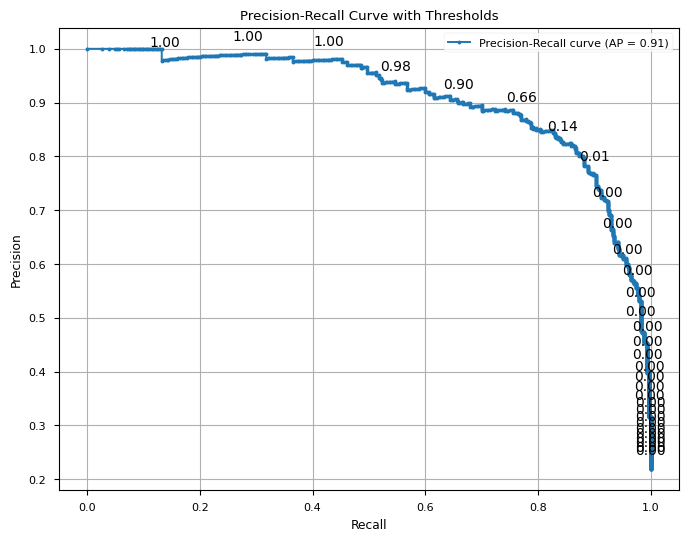

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute precision-recall curve and average precision score
precision, recall, thresholds = precision_recall_curve(val_labels, val_probs)
average_precision = average_precision_score(val_labels, val_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Precision-Recall curve (AP = {average_precision:.2f})')

# Plot points with thresholds
for i in range(len(thresholds)):
    if i % 50 == 0:  # Show every 50th threshold for clarity
        plt.annotate(f'{thresholds[i]:.2f}', (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Thresholds')
plt.legend()
plt.grid()
plt.show()


In [10]:
# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(val_labels, val_probs)
print(f"Best Threshold: {best_threshold}")

# Generate final predictions based on optimal f1 threshold
test_preds_0_1 = [1 if prob >= best_threshold else 0 for prob in test_probs]

# Generate final predictions based on optimal threshold
test_preds_0_5 = [1 if prob >= 0.5 else 0 for prob in test_probs]

Best Threshold: 0.1


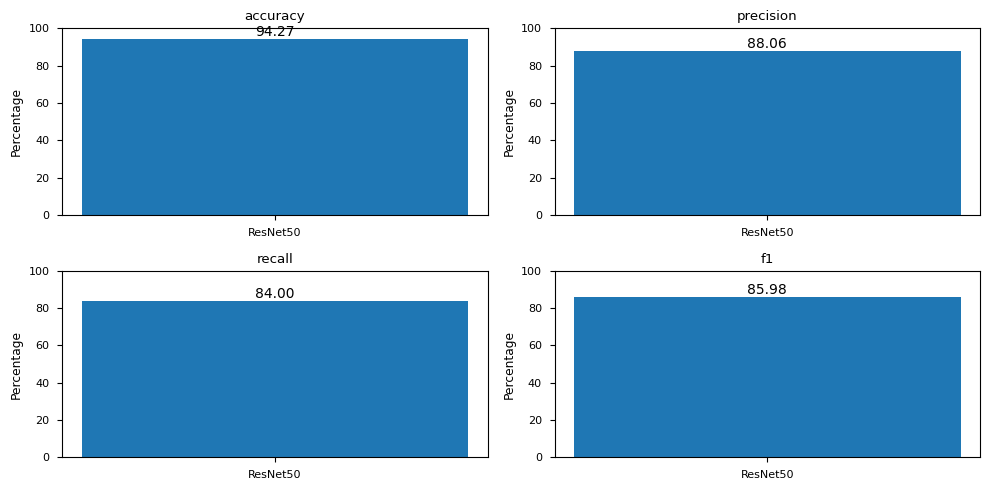

In [11]:
# Plotting the computed metrics

metrics = Metrics()
metrics.run(test_labels, test_preds_0_5, "ResNet50")
metrics.plot()

### Plot all models performance chart

/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_52277/3458341105.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(wrapped_labels, ha='center')
/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_52277/3458341105.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(wrapped_labels, ha='center')
/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_52277/3458341105.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(wrapped_labels, ha='center')
/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_52277/3458341105.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

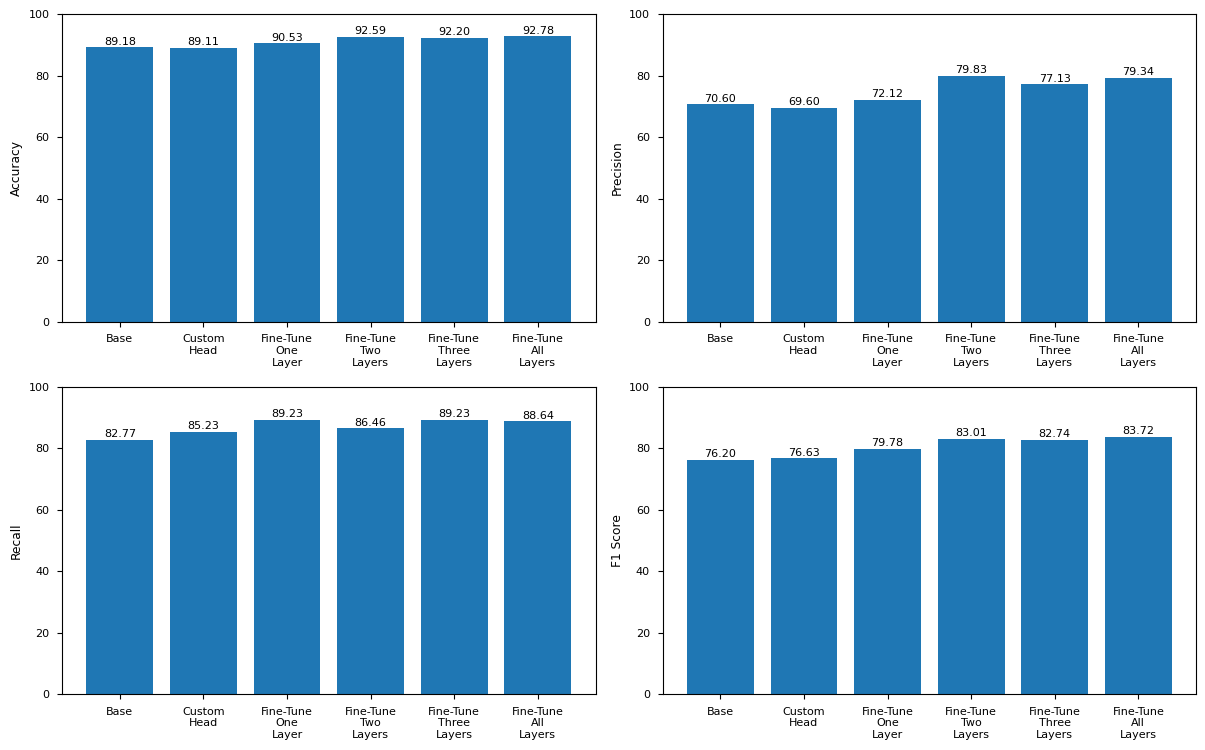

In [24]:
import matplotlib.pyplot as plt
import textwrap

# Data for the charts
models = ['Base', 'Custom Head', 'Fine-Tune One Layer', 'Fine-Tune Two Layers', 'Fine-Tune Three Layers', 'Fine-Tune All Layers']
accuracy = [89.18, 89.11, 90.53, 92.59, 92.20, 92.78]
precision = [70.60, 69.60, 72.12, 79.83, 77.13, 79.34]
recall = [82.77, 85.23, 89.23, 86.46, 89.23, 88.64]
f1 = [76.20, 76.63, 79.78, 83.01, 82.74, 83.72]

# Function to add labels on top of bars
def add_labels(ax, data):
    for i, v in enumerate(data):
        ax.text(i, v + 0.2, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

# Function to wrap text labels with each word on a new line
def wrap_labels(labels):
    wrapped_labels = []
    for label in labels:
        wrapped_label = '\n'.join(label.split())
        wrapped_labels.append(wrapped_label)
    return wrapped_labels

# Creating the subplots
fig, axs = plt.subplots(2, 2, figsize=(12.16, 7.6))

# Wrapped labels with each word on a new line
wrapped_labels = wrap_labels(models)

# Chart 1: Accuracy
axs[0, 0].bar(models, accuracy)
axs[0, 0].set_ylim(0, 100)
axs[0, 0].set_ylabel('Accuracy')
add_labels(axs[0, 0], accuracy)
axs[0, 0].set_xticklabels(wrapped_labels, ha='center')

# Chart 2: Precision
axs[0, 1].bar(models, precision)
axs[0, 1].set_ylim(0, 100)
axs[0, 1].set_ylabel('Precision')
add_labels(axs[0, 1], precision)
axs[0, 1].set_xticklabels(wrapped_labels, ha='center')

# Chart 3: Recall
axs[1, 0].bar(models, recall)
axs[1, 0].set_ylim(0, 100)
axs[1, 0].set_ylabel('Recall')  # Percentage
add_labels(axs[1, 0], recall)
axs[1, 0].set_xticklabels(wrapped_labels, ha='center')

# Chart 4: F1 Score
axs[1, 1].bar(models, f1)
axs[1, 1].set_ylim(0, 100)
axs[1, 1].set_ylabel('F1 Score')
add_labels(axs[1, 1], f1)
axs[1, 1].set_xticklabels(wrapped_labels, ha='center')

# Save the figure
plt.savefig('report_charts/ModelPerformance.pdf', bbox_inches='tight')

# Adjusting layout
plt.tight_layout()
plt.show()

# Confusion Matrix

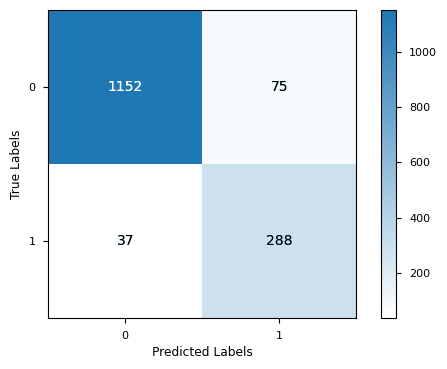

In [26]:
# Compute confusion matrix for the optimal threshold
conf_matrix = confusion_matrix(test_labels, test_preds_0_1)

# Use the first color (which is blue in many styles) to create a gradient
base_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_blue', ['white', base_color])

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(6.4, 4))
disp.plot(cmap=cmap, ax=ax)

# Manually adjust text colors for better readability
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center",
                       color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the figure
plt.savefig(
    'report_charts/ConfusionMatrix.pdf',
    bbox_inches='tight',
)

plt.show()

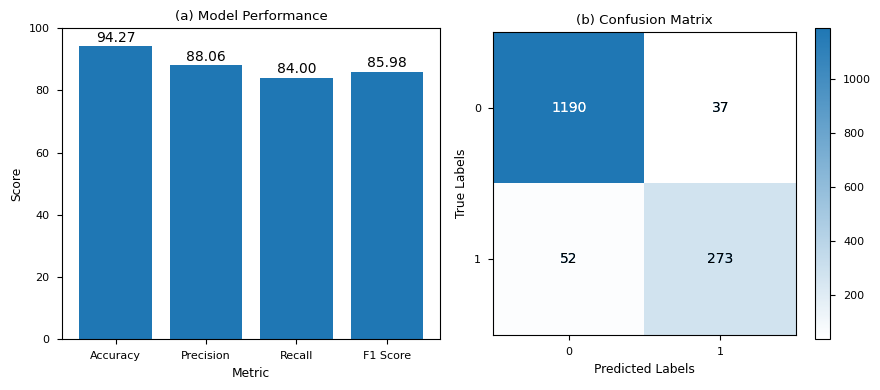

In [16]:
# Compute confusion matrix for 0.5 (the optimal model)
conf_matrix = confusion_matrix(test_labels, test_preds_0_5)

# Data for the optimal model performance
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [94.27, 88.06, 84.00, 85.98]

# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot 1: Optimal Model Performance
bars = axs[0].bar(metrics, scores)

# Add labels on top of the bars
for bar, score in zip(bars, scores):
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{score:.2f}', ha='center', va='bottom')

axs[0].set_ylim(0, 100)
axs[0].set_ylabel('Score')
axs[0].set_xlabel('Metric')
axs[0].set_title('(a) Model Performance')

# Plot 2: Confusion Matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=cmap, ax=axs[1], xticks_rotation='horizontal')

# Manually add text annotations with desired text colors
threshold = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        color = "white" if conf_matrix[i, j] > threshold else "black"
        axs[1].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color=color)

axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')
axs[1].set_title('(b) Confusion Matrix')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('report_charts/OptimalModel_and_ConfusionMatrix.pdf', bbox_inches='tight')
plt.show()


## Analysis of False Positives

Last plotted image index: 581


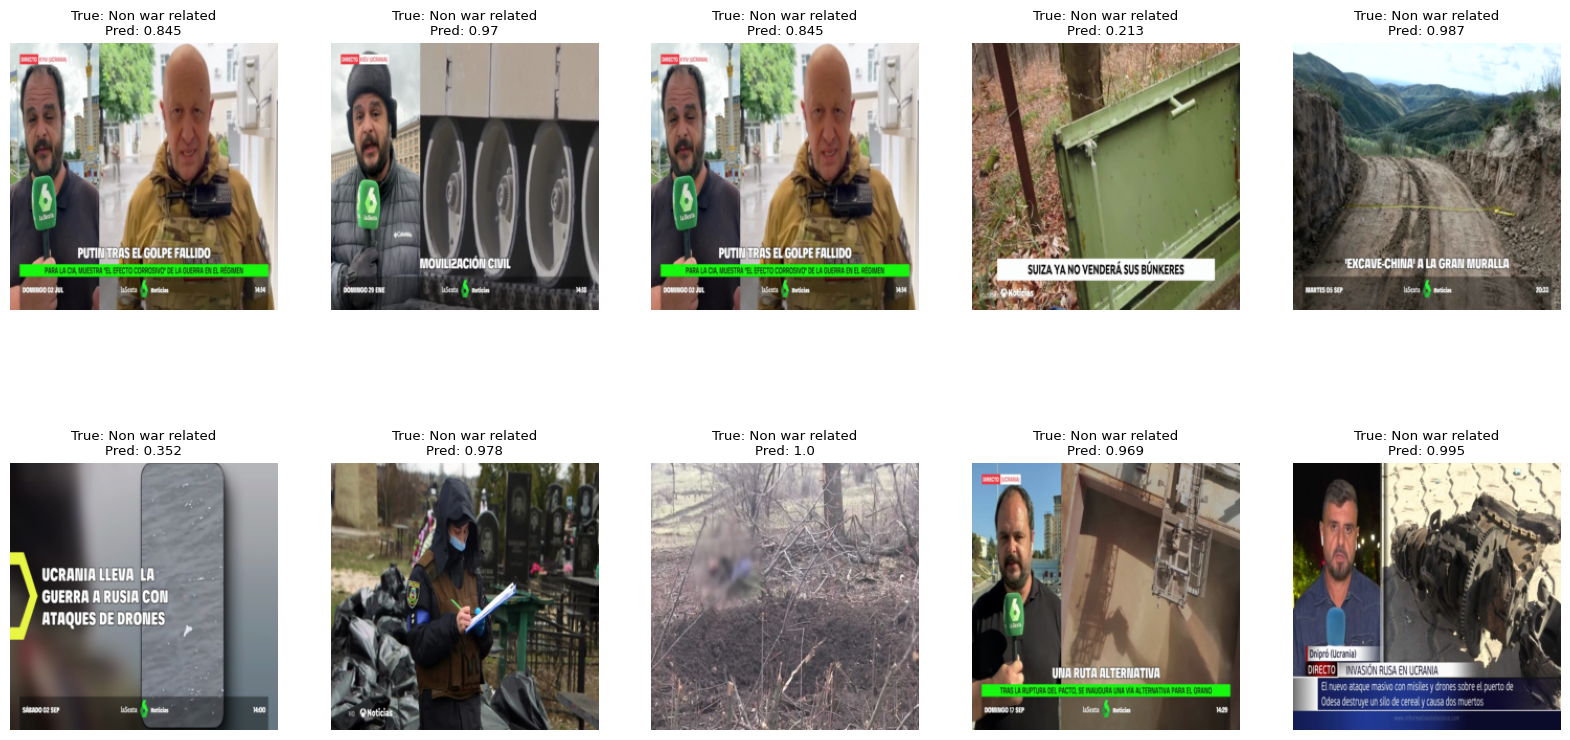

In [19]:
# test_preds = test_preds_0_5
test_preds = test_preds_0_1

resnet_eval = EvaluateImages(test_images, test_labels, test_preds, test_probs)
resnet_eval.plot_false_positives(332, probs=True)

## Analysis of False Negatives

Last plotted image index: 451


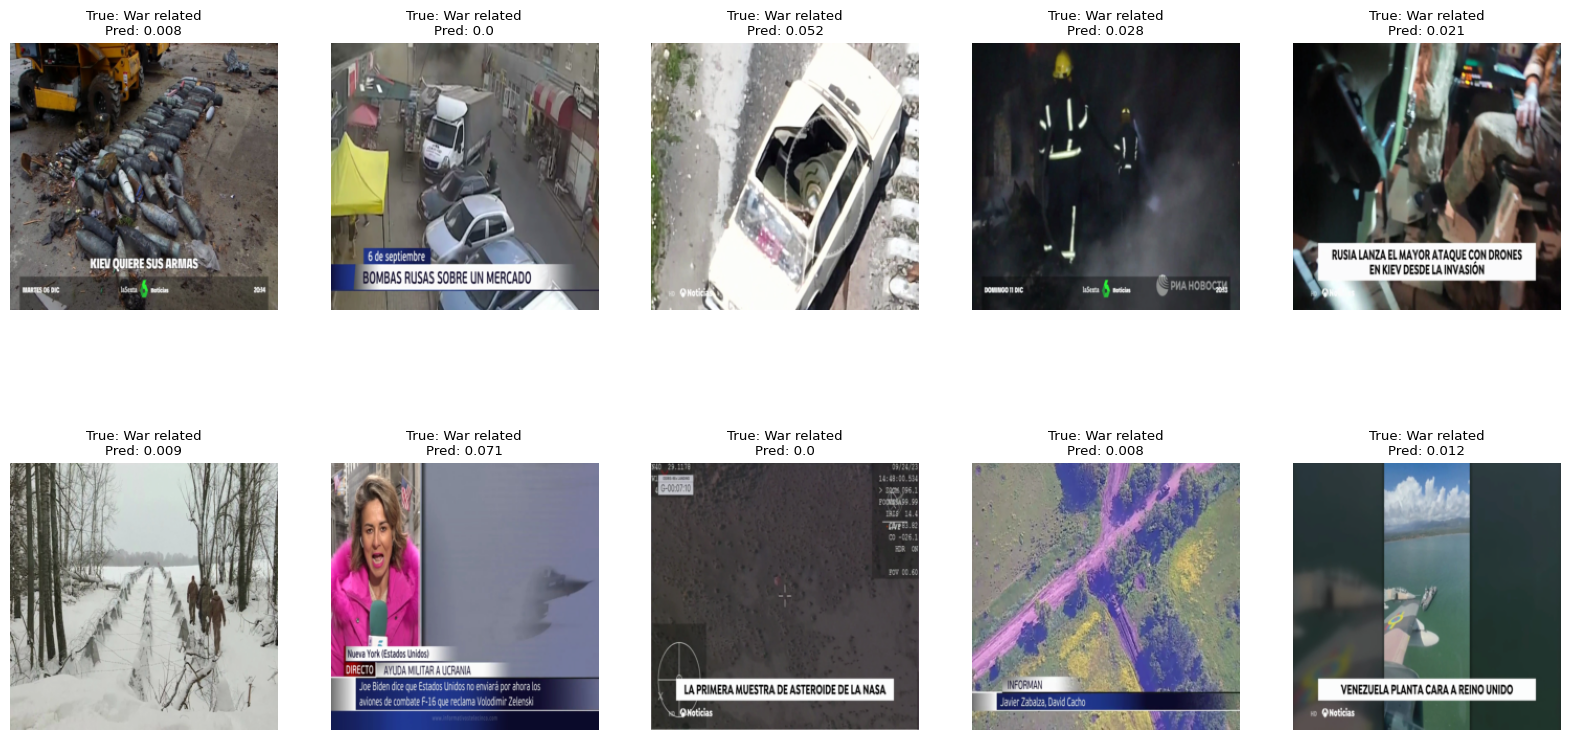

In [21]:
resnet_eval.plot_false_negatives(0, probs=True)

Last plotted image index: 539


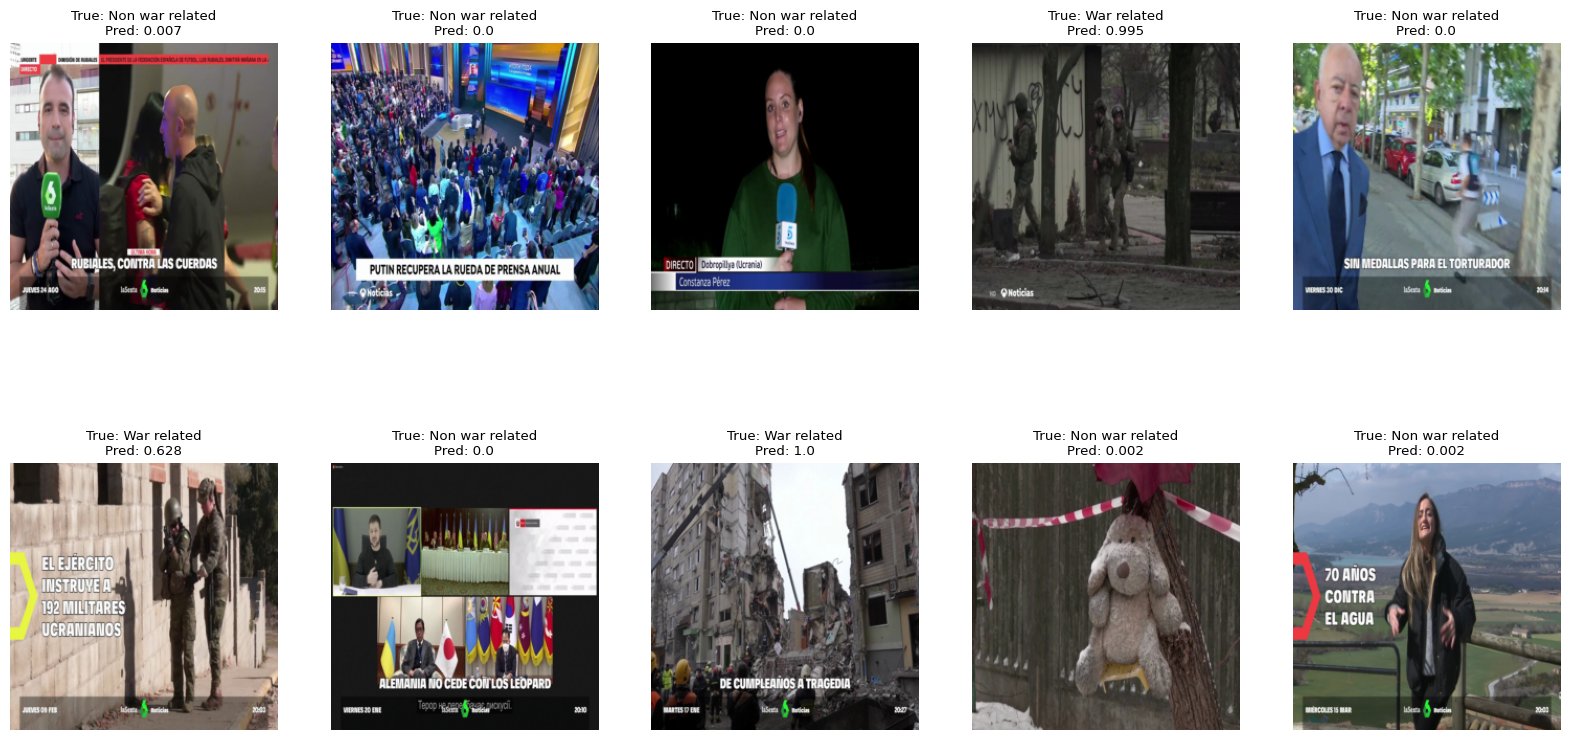

In [22]:
# Plot predictions and predictions
resnet_eval.plot_images(530, probs=True) 

## Feature Importance

### GradCAM

/Users/viktoriia/my_venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


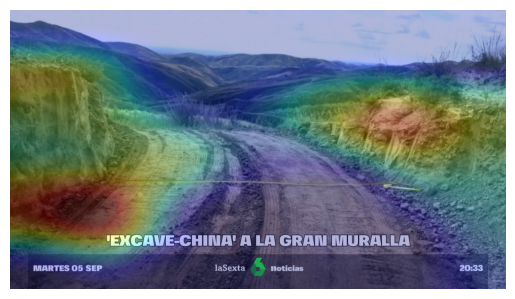

In [23]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        target = output[0][class_idx]
        target.backward()

        gradients = self.gradients
        activations = self.activations

        if gradients is None or activations is None:
            raise ValueError("Gradients or activations not properly set. Check the target layer and hooks.")

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
        heatmap /= np.max(heatmap)

        return heatmap

def preprocess_image(img_path, device):
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device)

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = np.uint8(Image.fromarray(heatmap).resize((img.shape[1], img.shape[0]), Image.Resampling.LANCZOS))
    heatmap = np.array(heatmap)

    # jet = plt.cm.get_cmap("jet")
    jet = plt.get_cmap("jet")
    jet_heatmap = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_heatmap[heatmap]

    jet_heatmap = np.uint8(jet_heatmap * 255)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img / np.max(superimposed_img) * 255)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Usage example
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load and preprocess the image
# img_path = '/Users/viktoriia/Desktop/new_labels/frames/frame_atres_noche_2023-01-10_sec_1370.jpg'  # destroyed
# img_path ='/Users/viktoriia/Desktop/new_labels/frames/frame_la6_noche_2023-01-17_sec_1470.jpg' # destroyed
# img_path = '/Users/viktoriia/Desktop/new_labels/frames/frame_la6_noche_2024-03-17_sec_1239.jpg'
# img_path = '/Users/viktoriia/Desktop/new_labels/frames/frame_la6_noche_2022-12-06_sec_714.jpg' #ship
# img_path = '/Users/viktoriia/Desktop/new_labels/frames/frame_atres_noche_2024-05-17_sec_1310.jpg'  #war in studio
img_path = '/Users/viktoriia/Desktop/new_labels/frames/frame_la6_noche_2023-09-05_sec_1799.jpg'  # field
image_tensor = preprocess_image(img_path, device)

# Load the trained model and set to evaluation mode
trained_model.eval()
trained_model.to(device)

# Grad-CAM
target_layer = "layer4.2"  # Change this to the correct last conv layer in your model
grad_cam = GradCAM(trained_model, target_layer)

# Forward pass
output = trained_model(image_tensor.to(device))
class_idx = torch.argmax(output).item()

# Generate and display heatmap
heatmap = grad_cam.generate_heatmap(image_tensor.to(device), class_idx)
display_gradcam(img_path, heatmap)


### Occlusion Sensitivity

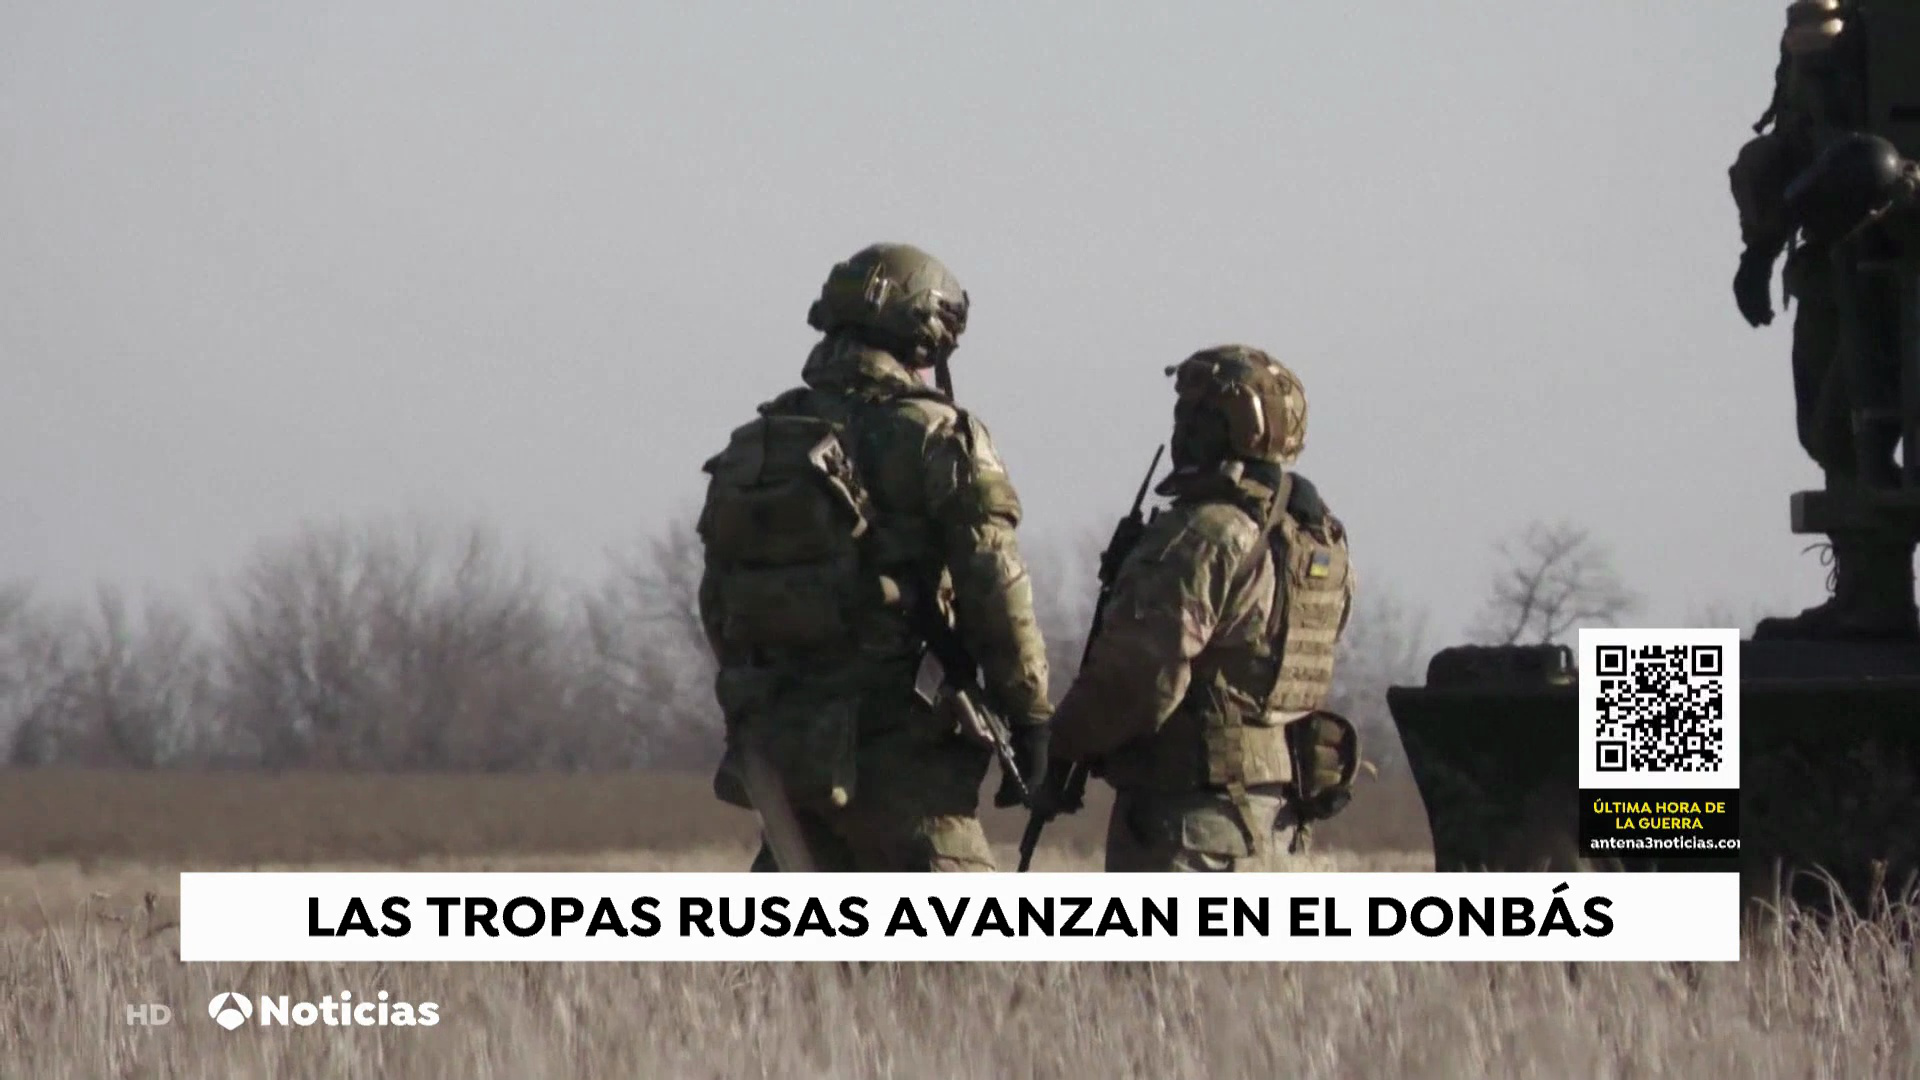

In [52]:
# Load and display the image
image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/all_frames/frame_atres_noche_2023-02-02_sec_1165.jpg'
image = Image.open(image_path)
image

In [53]:
# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [54]:
# Set the model to evaluation mode
trained_model.eval()

# Move the image tensor to the same device as the model
image_tensor = image_tensor.to(device)

# Get the prediction
with torch.no_grad():
    output = trained_model(image_tensor)
    probability = torch.sigmoid(output).item()

# Convert the probability to a binary prediction
prediction = 1 if probability > 0.5 else 0

# Print the prediction
labels = {0: 'Not war', 1: 'War'}
print(f"Predicted class: '{labels[prediction]}' with probability of war being: {probability:.4f}")

Predicted class: 'War' with probability of war being: 1.0000


In [110]:
# Define the same transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Plot the transformed image
transformed_image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and convert to HWC
transformed_image = transformed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
transformed_image = np.clip(transformed_image, 0, 1)  # Clip to valid range

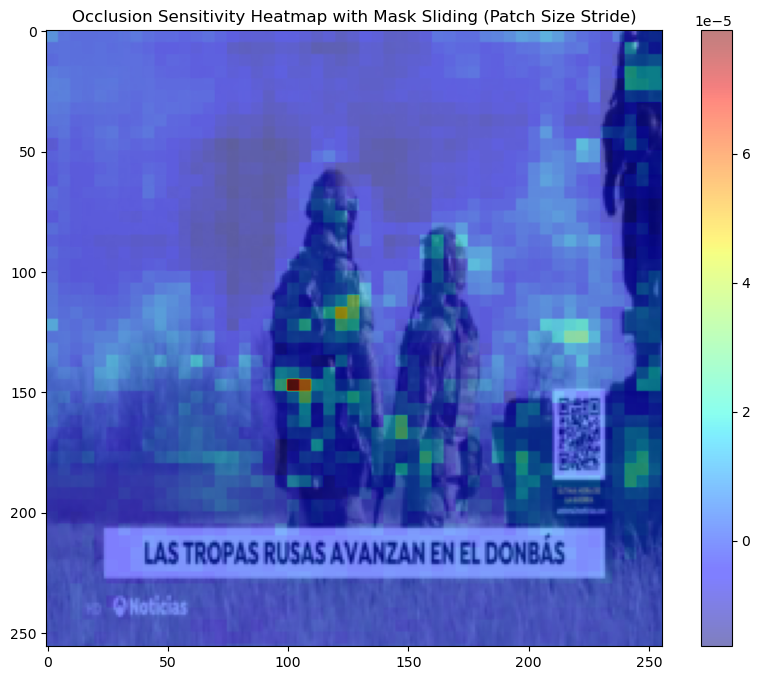

In [104]:
# Perform occlusion sensitivity analysis
trained_model.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity(trained_model, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()

### Occlusion Sensitivity (Reverse)

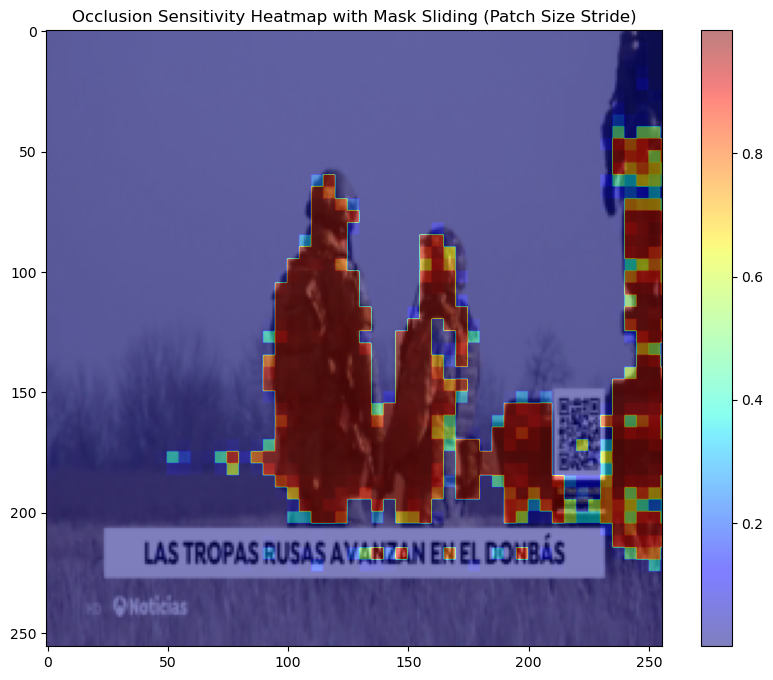

In [109]:
# Perform occlusion sensitivity analysis
trained_model.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity_mask(trained_model, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()